# Решающее дерево

### Примечание
### #
Данная лабораторная работа не относится напрямую к изучению питона в целом или какого то конкретного модуля. Задача взята из курса по машинному обучению.
Здесь я хочу проверить ваши умения разбираться в предлагаемом алгоритме и навыки в реализации этих алгоритмов.
Проведем эксперимент и посмотрим на результат. Если будут возникать непреодолимые трудности, то просьба не прибегать к копированию решений из интернета, а обртиться за помощью к коллегам либо преподавателю.
### #

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

In [1]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
%matplotlib inline

x, y = make_moons(n_samples=100, noise=0.1)

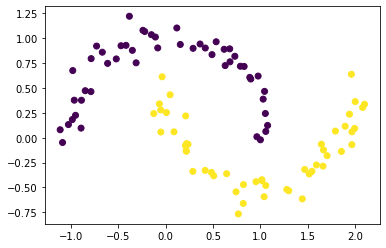

In [2]:
plt.scatter(x[:,0], x[:,1], c = y)

In [3]:
'-' * 3 + 'val'

'---val'


## Задание

Напишите класс дерева, который реализует метод train, которая получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает дерево в виде словаря в каждом случае записывается номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$). Вместо занчения в листовой вершине может содержаться следующий словарь с теми же ключами и так далее.

Необходимо учесть:

1. Возможность строить дерево строго определенной глубины и возможность указать минимальное количество объектов в узле.
2. Пороги разбиения должны лежать строго по середине между ближайшими обектами.
3. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
4. Количество различных классов объектов в целевой переменной может быть больше двух.


## Решение

In [4]:
### Вспомогательный код

class Node:
    def __init__(self, j=None, t=None, left=None, right=None, value=None):
        self.j = j
        self.t = t
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf(self):
        return self.value != None

def get_groups(data, key):
    return groupby(sorted(data, key=key), key)

def eval_gini_criterion(X):
    H_x = 0
    for k, group in get_groups(X, key=lambda x: x[-1]):
        x_in_k_count = len(list(group))
        p_k = x_in_k_count / len(X)
        H_x += p_k * (1 - p_k)

    return H_x

def eval_error(X_l, X_r):
    X_size = len(X_l) + len(X_r)
    return len(X_l) / X_size * eval_gini_criterion(X_l) + len(X_r) / X_size * eval_gini_criterion(X_r)

def get_params_for_searching(X):
    features_count = X.shape[1] - 1
    params = []
    
    for j in range(0, features_count):
        j_values_sort = sorted(X[:, j])
        t_values = [np.mean(v) for v in zip(j_values_sort[:-1], j_values_sort[1:])]
        params.append((j, t_values))
        
    return params

def get_partitions(X, min_num_leaf):
    error_value = np.inf
    res = (False, None, None, None, None)
    
    for j, t_values in get_params_for_searching(X):
        for t in t_values:
            left, right = [np.array(list(group)) for _, group in get_groups(X, key=lambda x: x[j] > t)]
            cur_error_value = eval_error(left, right)
            
            if cur_error_value == 0:
                return (False, None, None, None, None)
            if cur_error_value < error_value:
                if len(left) > min_num_leaf and len(right) > min_num_leaf:
                    error_value = cur_error_value
                    res = (True, j, t, left, right)
                    
    return res
        
#only for classification problem
def get_value_in_selection(X):
    assert len(X) > 0
    distribution = [[k, len(list(group))] for k, group in get_groups(X, key=lambda x: x[-1])]
    
    return max(distribution, key=lambda x: x[1])[0]

def build_tree(X, cur_depth, max_depth, min_num_leaf):
    if cur_depth == max_depth:
        return Node(value=get_value_in_selection(X))
    
    has_parts, j, t, left, right = get_partitions(X, min_num_leaf)
    
    if not has_parts:
        return Node(value=get_value_in_selection(X))
        
    left_node = build_tree(left, cur_depth + 1, max_depth, min_num_leaf)
    right_node = build_tree(right, cur_depth + 1, max_depth, min_num_leaf)
    
    return Node(j, t, left=left_node, right=right_node)

Класс дерева

In [9]:
def get_tree_str(cur_node, depth=0):
    if cur_node.is_leaf():
        return f"{'  ' * (depth)}(value: {cur_node.value})"
    
    cur_str = f"{'  ' * (depth)}(j: {cur_node.j}, t: {cur_node.t})\n"
    cur_str += f"{'  ' * (depth)}left: \n{get_tree_str(cur_node.left, depth+1)}\n"
    cur_str += f"{'  ' * (depth)}right: \n{get_tree_str(cur_node.right, depth+1)}"

    return cur_str

def validate_train_args(x, y):
    if len(x) != len(y):
        raise ValueError("x and y must be the same size")    

class Tree:
    def __init__(self, depth=1, min_num_leaf=1):
        self.tree = None
        self.depth = depth
        self.min_num_leaf = min_num_leaf
                
    def train(self, x, y):
        validate_train_args(x, y)
        # Получаем датасет в котором целевая переменная находится в последней колонке
        X = np.array(list(zip(*[x[:, j] for j in range(x.shape[1])], y)))
        self.tree = build_tree(X, cur_depth=0, max_depth=self.depth, min_num_leaf=self.min_num_leaf)
    
    def predict(self, x):
        if self.tree == None:
            raise Exception("you need train the Tree")
        cur_node = self.tree
        while True:
            if cur_node.is_leaf():
                return cur_node.value
            if x[cur_node.j] > cur_node.t:
                cur_node = cur_node.right
            else:
                cur_node = cur_node.left
    
    def __str__(self):
        if self.tree == None:
            return "I'm empty tree"
        
        return get_tree_str(self.tree)

Постройте решающее дерево с глубиной 1, 2 и 3.

Визуализируйте получившиеся результаты классификатора на плоскости. Для этого воспользуйтесь кодом ниже, чтобы построить поверхность. $t$ - порог разбиения $i$ - номер признака.

In [10]:
### Строим деревья

tree_d1 = Tree(1)
tree_d1.train(x, y)

tree_d2 = Tree(2, 2)
tree_d2.train(x, y)

tree_d3 = Tree(3)
tree_d3.train(x, y)

In [11]:
print(tree_d2)

(j: 1, t: 0.3700530761503851)
left: 
  (j: 0, t: -0.5100183366219474)
  left: 
    (value: 0.0)
  right: 
    (value: 1.0)
right: 
  (j: 1, t: 0.6565667951699345)
  left: 
    (value: 0.0)
  right: 
    (value: 0.0)


In [12]:
test_tree = Tree(3, 2)
test_tree.train(x, y)

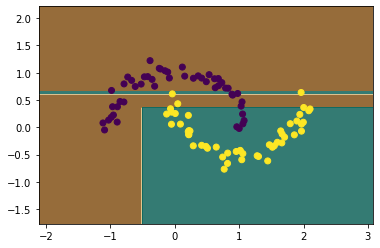

In [13]:
def tree_clf(x):
    y_pred = list()
    for it in x.transpose():
        # Алгоритм классификации
        y_pred.append(test_tree.predict(it)) # Используем решающее дерево
        #y_pred.append(np.round(np.random.random())) # Пока дерево классифицирует случайный класс.
    return np.array(y_pred)


h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)

cm = plt.cm.BrBG
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)